# Exploratory Data Analysis

## Setup

**Imports:**

In [42]:
%reload_ext autoreload
%autoreload 1
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import auxiliary.statistics as st
import auxiliary.eda_functions as eda
from IPython.display import Markdown,display
import matplotlib.ticker as ticker
%aimport auxiliary.statistics
%aimport auxiliary.lists
%aimport auxiliary.transformers
%aimport auxiliary.eda_functions


**Settings:**

In [2]:
sns.set()
BASE_FIG_SIZE = (8.5, 4.5)
ALPHA = 0.05

**Data Imports:**

In [3]:
application_train = pl.read_csv("data/application_train.csv")
bureau_balance = pl.read_csv("data/bureau_balance.csv")
bureau = pl.read_csv("data/bureau.csv")
installments_payments = pl.read_csv("data/installments_payments.csv")
POS_CASH_balance = pl.read_csv("data/POS_CASH_balance.csv")
previous_application = pl.read_csv("data/previous_application.csv")
credit_card_balance = pl.read_csv("data/credit_card_balance.csv")
id_and_target = ["SK_ID_CURR", "TARGET"]

## Data Integrity

This section explores missing values in the main table and sample references in other tables.

**Data base schema:**

![alt text](summary_data/home_credit.png "Title"){: width="800"}

**First few rows of the main table:**

In [4]:
application_train.head()

SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,…,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
i64,i64,str,str,str,str,i64,f64,f64,f64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,str,i64,i64,i64,i64,…,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64
100002,1,"""Cash loans""","""M""","""N""","""Y""",0,202500.0,406597.5,24700.5,351000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.018801,-9461,-637,-3648.0,-2120,null,1,1,0,1,1,0,"""Laborers""",1.0,2,2,"""WEDNESDAY""",10,0,0,0,…,0.0,"""reg oper accou…","""block of flats…",0.0149,"""Stone, brick""","""No""",2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,"""Cash loans""","""F""","""N""","""N""",0,270000.0,1293502.5,35698.5,1.1295e6,"""Family""","""State servant""","""Higher educati…","""Married""","""House / apartm…",0.003541,-16765,-1188,-1186.0,-291,null,1,1,0,1,1,0,"""Core staff""",2.0,1,1,"""MONDAY""",11,0,0,0,…,0.01,"""reg oper accou…","""block of flats…",0.0714,"""Block""","""No""",1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,"""Revolving loan…","""M""","""Y""","""Y""",0,67500.0,135000.0,6750.0,135000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,"""Laborers""",1.0,2,2,"""MONDAY""",9,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,"""Cash loans""","""F""","""N""","""Y""",0,135000.0,312682.5,29686.5,297000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Civil marriage…","""House / apartm…",0.008019,-19005,-3039,-9833.0,-2437,null,1,1,0,1,0,0,"""Laborers""",2.0,2,2,"""WEDNESDAY""",17,0,0,0,…,null,null,null,null,null,null,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null
100007,0,"""Cash loans""","""M""","""N""","""Y""",0,121500.0,513000.0,21865.5,513000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.028663,-19932,-3038,-4311.0,-3458,null,1,1,0,1,0,0,"""Core staff""",1.0,2,2,"""THURSDAY""",11,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


**Are there any duplicate ID's in the main table?**

In [5]:
application_train["SK_ID_CURR"].is_duplicated().any()

False

### Missing Values


**Missing value graphical overview:**

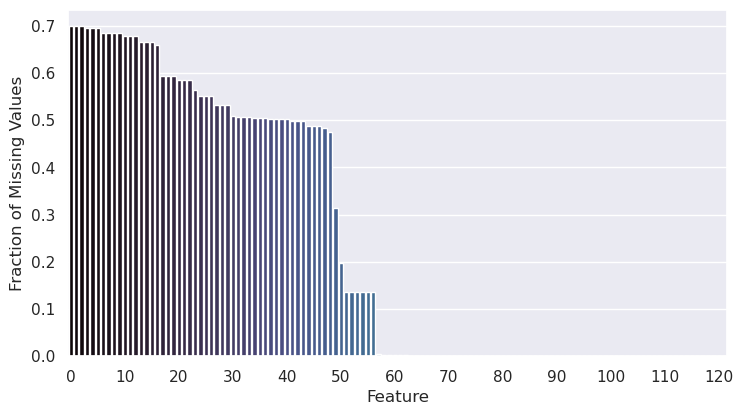

In [6]:
missing_values_main = pl.DataFrame(
    {
        "missing_fraction": application_train.null_count().transpose().to_series()
        / len(application_train),
        "feature": application_train.columns,
    }
).sort("missing_fraction", descending=True)

fig_main_missing, ax_main_missing = plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(
    x=missing_values_main["feature"].to_numpy(),
    y=missing_values_main["missing_fraction"].to_numpy(),
    hue=missing_values_main["feature"].to_numpy(),
    legend=False,
    ax=ax_main_missing,
    palette=sns.color_palette("mako", n_colors=len(missing_values_main)),
)
ax_main_missing.set_xticks(np.arange(len(missing_values_main), step=10))
ax_main_missing.set_xticklabels(np.arange(len(missing_values_main), step=10))
ax_main_missing.set_xlabel("Feature")
ax_main_missing.set_ylabel("Fraction of Missing Values")
plt.show()

**Features with most missing values:**

In [7]:
eda.table_display(missing_values_main[:10])

|   missing_fraction | feature                  |
|-------------------:|:-------------------------|
|           0.698723 | COMMONAREA_AVG           |
|           0.698723 | COMMONAREA_MODE          |
|           0.698723 | COMMONAREA_MEDI          |
|           0.69433  | NONLIVINGAPARTMENTS_AVG  |
|           0.69433  | NONLIVINGAPARTMENTS_MODE |
|           0.69433  | NONLIVINGAPARTMENTS_MEDI |
|           0.683862 | FONDKAPREMONT_MODE       |
|           0.68355  | LIVINGAPARTMENTS_AVG     |
|           0.68355  | LIVINGAPARTMENTS_MODE    |
|           0.68355  | LIVINGAPARTMENTS_MEDI    |

### References in other tables

**Percentage of users with reference in other tables:**

In [8]:
tables_with_reference = {
    "Bureau": bureau,
    "Positive Cash Balance": POS_CASH_balance,
    "Credit Card Balance": credit_card_balance,
    "Previous Application": previous_application,
    "Installments Payments": installments_payments,
}

for name, table in tables_with_reference.items():
    frac_with_reference = len(
        application_train.filter(pl.col("SK_ID_CURR").is_in(table["SK_ID_CURR"]))
    ) / len(application_train)
    display(
        Markdown(
            f"{round(frac_with_reference*100)}% of users have reference in {name} table."
        )
    )

86% of users have reference in Bureau table.

94% of users have reference in Positive Cash Balance table.

28% of users have reference in Credit Card Balance table.

95% of users have reference in Previous Application table.

95% of users have reference in Installments Payments table.

Most of the applicants have information about them in the credit bureau and 95% of them had previous applications. Only 28% of applicants have a credit card history.

**Number of references per user:**

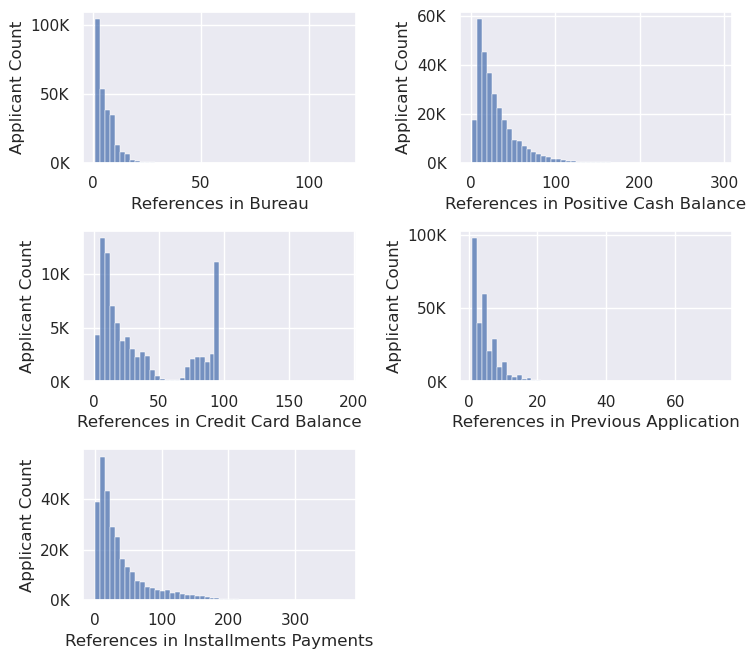

In [9]:
fig_reference_counts, ax_reference_counts = plt.subplots(
    3, 2, figsize=(BASE_FIG_SIZE[0]*0.9, BASE_FIG_SIZE[1] * 1.5)
)
ax_reference_counts = ax_reference_counts.flatten()

for i, (name, table) in enumerate(tables_with_reference.items()):
    count_table = table.filter(
        pl.col("SK_ID_CURR").is_in(application_train["SK_ID_CURR"])
    )["SK_ID_CURR"].value_counts()

    sns.histplot(count_table["counts"], ax=ax_reference_counts[i], bins=50)
    # ax_reference_counts[i].set_title(name)
    ax_reference_counts[i].set_xlabel(f"References in {name}")
    ax_reference_counts[i].set_ylabel("Applicant Count")
    ax_reference_counts[i].yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,g}".format(x / 1000) + "K")
    )
plt.delaxes(ax_reference_counts[-1])
plt.tight_layout()
plt.show()

## Application Table Feature Analysis

**Most promising features:**

In [43]:
initial_test = eda.test_with_catboost_crossval(
    X=application_train.drop(columns=id_and_target),
    y=application_train["TARGET"],
    sample_size=50000,
)
joblib.dump(initial_test,"summary_data/initial_test.joblib")
eda.table_display(initial_test["features"][:20])

| feature                    |   importance |
|:---------------------------|-------------:|
| EXT_SOURCE_3               |      9.49508 |
| EXT_SOURCE_2               |      8.94928 |
| EXT_SOURCE_1               |      5.76733 |
| DAYS_BIRTH                 |      5.26519 |
| AMT_CREDIT                 |      4.33955 |
| AMT_ANNUITY                |      3.99456 |
| DAYS_ID_PUBLISH            |      3.91373 |
| DAYS_EMPLOYED              |      3.47728 |
| DAYS_LAST_PHONE_CHANGE     |      3.47288 |
| AMT_GOODS_PRICE            |      3.23805 |
| DAYS_REGISTRATION          |      2.7918  |
| REGION_POPULATION_RELATIVE |      2.09828 |
| AMT_INCOME_TOTAL           |      2.03654 |
| HOUR_APPR_PROCESS_START    |      1.76779 |
| OCCUPATION_TYPE            |      1.7285  |
| NAME_EDUCATION_TYPE        |      1.68306 |
| AMT_REQ_CREDIT_BUREAU_YEAR |      1.4442  |
| NAME_FAMILY_STATUS         |      1.29938 |
| CODE_GENDER                |      1.26547 |
| NAME_INCOME_TYPE           |      1.25644 |

It's evident that the company leverages valuable external source data. Additionally, key applicant attributes such as age, employment length, credit size, and similar features emerge as particularly promising variables.

### External data analysis

**Visualizing external data:**

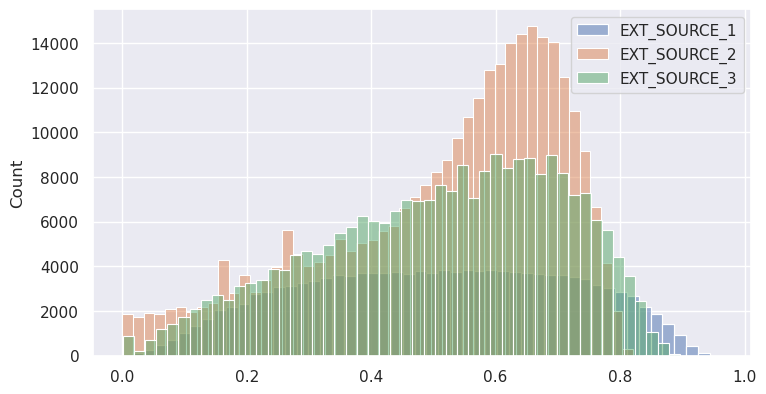

In [11]:
fig_source_data, ax_source_data = plt.subplots(figsize=BASE_FIG_SIZE)
for source_data in ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]:
    sns.histplot(
        application_train[source_data],
        ax=ax_source_data,
        bins=50,
        label=source_data,
        alpha=0.5,
    )
    ax_source_data.legend()
plt.show()

**Missing values in external data**

In [12]:
application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].null_count()

EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
u32,u32,u32
173378,660,60965


External data seems to be scaled from 0 to 1, normally or approximately normally distributed.

### Categorical Features In The Application Table

In [13]:
application_cat_cols = application_train.select(pl.col(pl.Utf8)).columns

**Education and family status:**

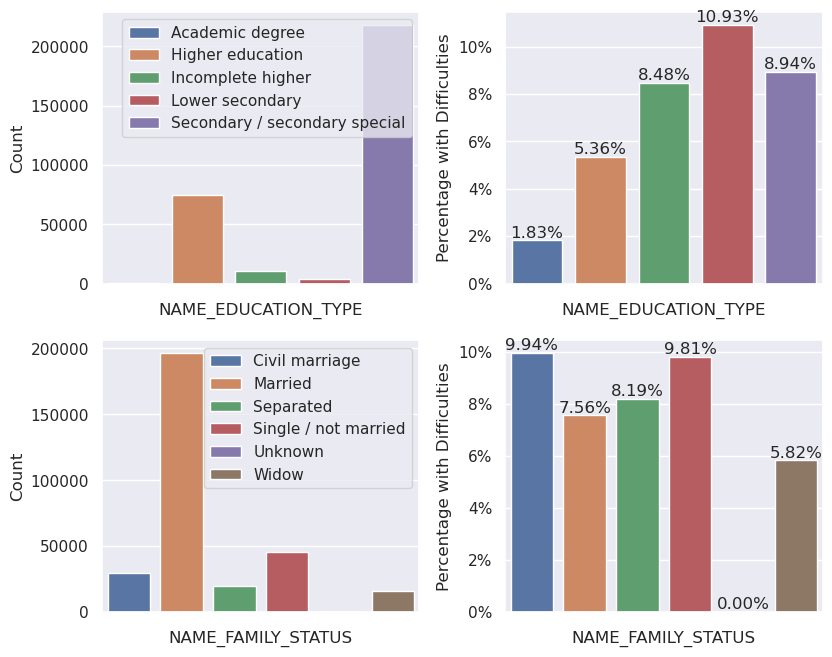

In [14]:
fig_main_cats, ax_main_cats = plt.subplots(
    2, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 1.5)
)
for i, col in enumerate(["NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS"]):
    sns.countplot(
        x=application_train.sort(col)[col].to_numpy(),
        hue=application_train.sort(col)[col].to_numpy(),
        ax=ax_main_cats[i, 0],
        legend=True,
    )
    agg_df = (
        application_train[[col, "TARGET"]]
        .group_by(col)
        .agg(pl.col("TARGET").sum().alias("TARGET"), pl.all().count().alias("count"))
        .with_columns((pl.col("TARGET") / pl.col("count")).alias("frac") * 100)
    ).sort(col)

    sns.barplot(
        x=agg_df.sort(col)[col].to_numpy(),
        y=agg_df.sort(col)["frac"].to_numpy(),
        hue=agg_df[col].to_numpy(),
        ax=ax_main_cats[i, 1],
        legend=False,
    )

    ax_main_cats[i, 0].set_xticklabels([])
    ax_main_cats[i, 1].set_xticklabels([])
    ax_main_cats[i, 0].set_xlabel(col)
    ax_main_cats[i, 1].set_xlabel(col)
    for container in ax_main_cats[i, 1].containers:
        ax_main_cats[i, 1].bar_label(container, fmt="%.2f%%", label_type="edge")
    sns.move_legend(ax_main_cats[i, 0], "upper right")
    ax_main_cats[i, 1].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax_main_cats[i, 0].set_ylabel("Count")
    ax_main_cats[i, 1].set_ylabel("Percentage with Difficulties")
plt.tight_layout()
plt.show()

**Occupation**

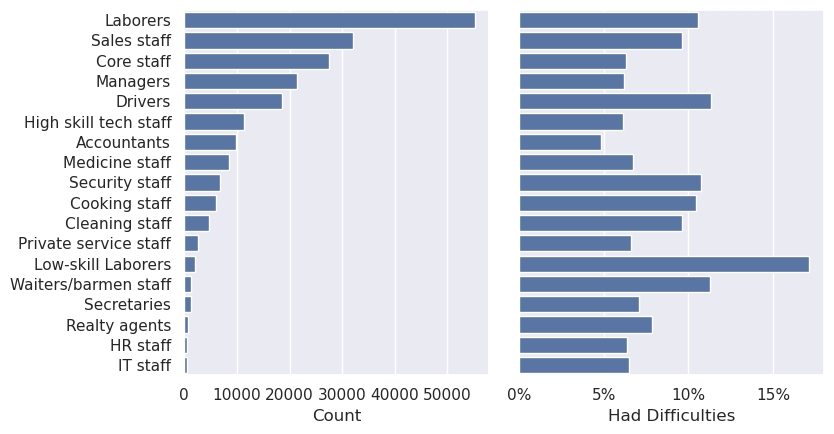

In [15]:
occupation_df = (
    application_train.group_by("OCCUPATION_TYPE")
    .agg(pl.count(), pl.col("TARGET").sum())
    .with_columns(
        (pl.col("TARGET") * 100 / pl.col("count")).alias("Frac With Difficulties")
    )
    .sort("count", descending=True)
)

fig_occ, ax_occ = plt.subplots(1, 2, figsize=BASE_FIG_SIZE, sharey=True)
sns.barplot(
    y=occupation_df["OCCUPATION_TYPE"].to_numpy(),
    x=occupation_df["count"].to_numpy(),
    ax=ax_occ[0],
)
ax_occ[0].set_xlabel("Count")

sns.barplot(
    y=occupation_df["OCCUPATION_TYPE"].to_numpy(),
    x=occupation_df["Frac With Difficulties"].to_numpy(),
    ax=ax_occ[1],
)
ax_occ[1].set_xlabel("Had Difficulties")
ax_occ[1].xaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

plt.tight_layout()
plt.show()

The analysis reveals distinctions in default risk associated with applicants' education and family status and occupation.

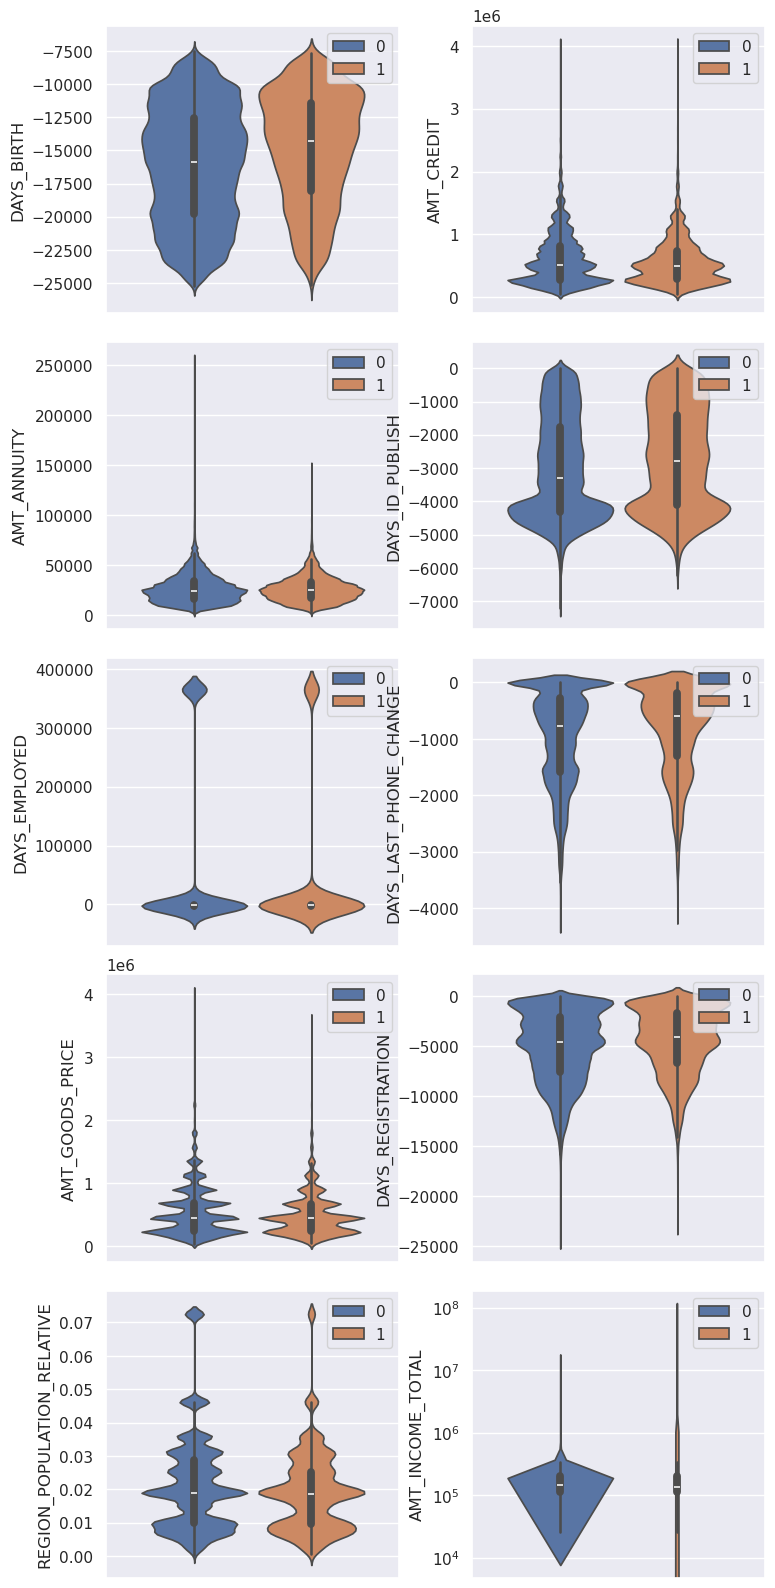

In [16]:
interesting_num_features = [
    i
    for i in initial_test["features"][:13, 0]
    if (i not in application_cat_cols and i[:3] != "EXT")
]

fig_num_box, ax_num_box = plt.subplots(
    5, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 2.5)
)
ax_num_box = ax_num_box.flatten()

for i, col in enumerate(interesting_num_features):
    sns.violinplot(
        y=application_train[col].to_numpy(),
        hue=application_train["TARGET"].to_numpy(),
        ax=ax_num_box[i],
        gap=0.1,
    )
    ax_num_box[i].set_ylabel(col)
ax_num_box[-1].set_yscale("log")
plt.subplots_adjust(bottom=-0.5, wspace=0.25, hspace=0.1)
plt.show()

### Statistical Significance of Feature and Target Relationship

This section explores wether there are significant relationships between target and the features in the application table.

**Sorting the features into categorical and numerical:**

In [17]:
application_cat_features = [
    feature
    for feature in application_train.columns
    if (application_train[feature].n_unique() < 30 and feature not in id_and_target)
]

application_num_features = [
    feature
    for feature in application_train.select(
        [pl.col(pl.INTEGER_DTYPES), pl.col(pl.FLOAT_DTYPES)]
    ).columns
    if (feature not in application_cat_features and feature not in id_and_target)
]

**Chi-square test for categorical features with the null hypothesis that here is no significant relationship with the target:**

In [18]:
target_squares = {}
cat_feature_significance = pl.DataFrame(
    schema={"Feature": pl.Utf8, "Significance": pl.Boolean}
)
for feature in application_cat_features:
    target_squares[feature] = st.chi_squared_polars(
        application_train, "TARGET", feature, alpha=ALPHA
    )
    significance = target_squares[feature]["p_value"] <= ALPHA
    cat_feature_significance = cat_feature_significance.vstack(
        pl.DataFrame({"Feature": feature, "Significance": bool(significance)})
    )

**Categoric features with a significant relationship with the target:**

In [19]:
eda.table_display(cat_feature_significance.filter(pl.col("Significance")))

| Feature                     | Significance   |
|:----------------------------|:---------------|
| NAME_CONTRACT_TYPE          | True           |
| CODE_GENDER                 | True           |
| FLAG_OWN_CAR                | True           |
| FLAG_OWN_REALTY             | True           |
| CNT_CHILDREN                | True           |
| NAME_TYPE_SUITE             | True           |
| NAME_INCOME_TYPE            | True           |
| NAME_EDUCATION_TYPE         | True           |
| NAME_FAMILY_STATUS          | True           |
| NAME_HOUSING_TYPE           | True           |
| FLAG_EMP_PHONE              | True           |
| FLAG_WORK_PHONE             | True           |
| FLAG_PHONE                  | True           |
| OCCUPATION_TYPE             | True           |
| CNT_FAM_MEMBERS             | True           |
| REGION_RATING_CLIENT        | True           |
| REGION_RATING_CLIENT_W_CITY | True           |
| HOUR_APPR_PROCESS_START     | True           |
| REG_REGION_NOT_LIVE_REGION  | True           |
| REG_REGION_NOT_WORK_REGION  | True           |
| REG_CITY_NOT_LIVE_CITY      | True           |
| REG_CITY_NOT_WORK_CITY      | True           |
| LIVE_CITY_NOT_WORK_CITY     | True           |
| ELEVATORS_MODE              | True           |
| FLOORSMAX_MODE              | True           |
| FLOORSMIN_MODE              | True           |
| FONDKAPREMONT_MODE          | True           |
| HOUSETYPE_MODE              | True           |
| WALLSMATERIAL_MODE          | True           |
| EMERGENCYSTATE_MODE         | True           |
| DEF_30_CNT_SOCIAL_CIRCLE    | True           |
| DEF_60_CNT_SOCIAL_CIRCLE    | True           |
| FLAG_DOCUMENT_2             | True           |
| FLAG_DOCUMENT_3             | True           |
| FLAG_DOCUMENT_6             | True           |
| FLAG_DOCUMENT_8             | True           |
| FLAG_DOCUMENT_13            | True           |
| FLAG_DOCUMENT_14            | True           |
| FLAG_DOCUMENT_15            | True           |
| FLAG_DOCUMENT_16            | True           |
| FLAG_DOCUMENT_18            | True           |
| AMT_REQ_CREDIT_BUREAU_MON   | True           |
| AMT_REQ_CREDIT_BUREAU_QRT   | True           |
| AMT_REQ_CREDIT_BUREAU_YEAR  | True           |

**Kruskal Wallis test with the null hypothesis that there is no difference in specific numeric feature between different target groups:**

In [20]:
target_kruskal = {}
num_feature_significance = pl.DataFrame(
    schema={"Feature": pl.Utf8, "Significance": pl.Boolean}
)
for feature in application_num_features:
    target_kruskal[feature] = st.kruskal_polars(
        application_train, "TARGET", feature, alpha=ALPHA
    )
    significance = target_kruskal[feature]["p_value"] <= ALPHA
    num_feature_significance = num_feature_significance.vstack(
        pl.DataFrame({"Feature": feature, "Significance": bool(significance)})
    )

**Numeric features that have a significant relationship to the target:**

In [21]:
eda.table_display(num_feature_significance.filter(pl.col("Significance")))

| Feature                      | Significance   |
|:-----------------------------|:---------------|
| DAYS_BIRTH                   | True           |
| DAYS_EMPLOYED                | True           |
| DAYS_ID_PUBLISH              | True           |
| AMT_INCOME_TOTAL             | True           |
| AMT_CREDIT                   | True           |
| AMT_GOODS_PRICE              | True           |
| REGION_POPULATION_RELATIVE   | True           |
| DAYS_REGISTRATION            | True           |
| OWN_CAR_AGE                  | True           |
| EXT_SOURCE_1                 | True           |
| EXT_SOURCE_2                 | True           |
| EXT_SOURCE_3                 | True           |
| APARTMENTS_AVG               | True           |
| BASEMENTAREA_AVG             | True           |
| YEARS_BEGINEXPLUATATION_AVG  | True           |
| YEARS_BUILD_AVG              | True           |
| COMMONAREA_AVG               | True           |
| ELEVATORS_AVG                | True           |
| ENTRANCES_AVG                | True           |
| FLOORSMAX_AVG                | True           |
| FLOORSMIN_AVG                | True           |
| LANDAREA_AVG                 | True           |
| LIVINGAPARTMENTS_AVG         | True           |
| LIVINGAREA_AVG               | True           |
| NONLIVINGAREA_AVG            | True           |
| APARTMENTS_MODE              | True           |
| BASEMENTAREA_MODE            | True           |
| YEARS_BEGINEXPLUATATION_MODE | True           |
| YEARS_BUILD_MODE             | True           |
| COMMONAREA_MODE              | True           |
| ENTRANCES_MODE               | True           |
| LANDAREA_MODE                | True           |
| LIVINGAPARTMENTS_MODE        | True           |
| LIVINGAREA_MODE              | True           |
| NONLIVINGAREA_MODE           | True           |
| APARTMENTS_MEDI              | True           |
| BASEMENTAREA_MEDI            | True           |
| YEARS_BEGINEXPLUATATION_MEDI | True           |
| YEARS_BUILD_MEDI             | True           |
| COMMONAREA_MEDI              | True           |
| ELEVATORS_MEDI               | True           |
| ENTRANCES_MEDI               | True           |
| FLOORSMAX_MEDI               | True           |
| FLOORSMIN_MEDI               | True           |
| LANDAREA_MEDI                | True           |
| LIVINGAPARTMENTS_MEDI        | True           |
| LIVINGAREA_MEDI              | True           |
| NONLIVINGAREA_MEDI           | True           |
| TOTALAREA_MODE               | True           |
| OBS_30_CNT_SOCIAL_CIRCLE     | True           |
| OBS_60_CNT_SOCIAL_CIRCLE     | True           |
| DAYS_LAST_PHONE_CHANGE       | True           |

Given that there are subsequent feature selection steps and to avoid filtering out features that may provide valuable conditional information for tree-based models, it has been decided not to remove any features at this juncture.

### Section Summary

In this section, several key findings were identified:

1. The company relies on well-prepared external data, which proves to be highly valuable in predicting default risk.

2. Applicant characteristics, such as age, occupation, and family status, emerge as informative factors in determining default risk.

3. Characteristics of the loan itself, particularly the loan amount, demonstrate significance as features influencing default risk.

These insights collectively contribute to a more comprehensive understanding of the factors influencing default probabilities, providing a foundation for effective risk assessment and mitigation strategies.

## Credit Bureau Information

The credit bureau is an institution that acquires and stores data about the applicants credit history and status. This section explores this portion of the data.

**Total and active credits by the applicants according to credit bureau:**

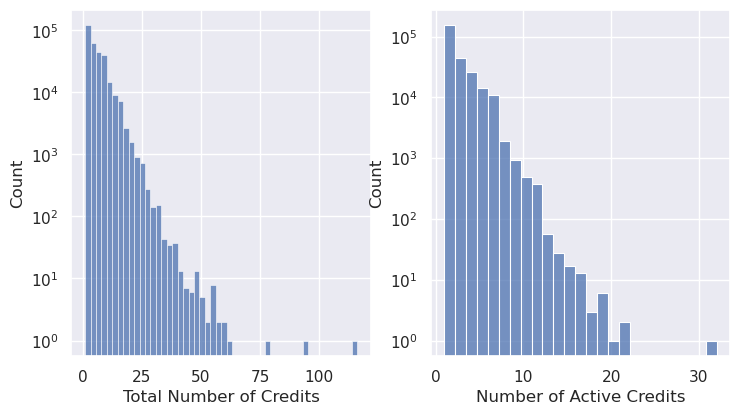

In [22]:
fig_bureau_entries, ax_bureau_entries = plt.subplots(1, 2, figsize=BASE_FIG_SIZE)
sns.histplot(
    bureau.group_by("SK_ID_CURR").agg(pl.count())["count"],
    bins=50,
    ax=ax_bureau_entries[0],
)
ax_bureau_entries[0].set_xlabel("Total Number of Credits")
ax_bureau_entries[0].set_yscale("log")
sns.histplot(
    bureau.filter(pl.col("CREDIT_ACTIVE") == "Active")
    .group_by("SK_ID_CURR")
    .agg(pl.count())["count"],
    bins=25,
    ax=ax_bureau_entries[1],
)
ax_bureau_entries[1].set_yscale("log")
ax_bureau_entries[1].set_xlabel("Number of Active Credits")
plt.show()

### Overdue Credits

Some of the active credits are overdue; in this context, exploration is conducted to understand the duration and amount associated with these overdue cases.

**The number of credits that are over due:**

In [23]:
bureau.select(
    (pl.col("CREDIT_ACTIVE") == "Active") & (pl.col("CREDIT_DAY_OVERDUE") > 0)
).sum()

CREDIT_ACTIVE
u32
4044


**The number of days that credits are overdue:**

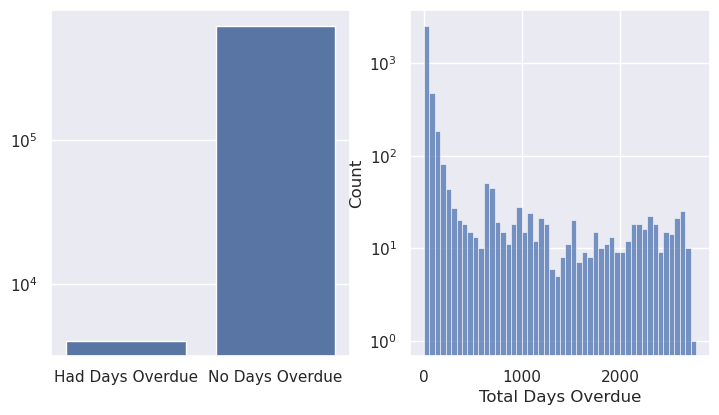

In [24]:
fig_days_over_bur, ax_days_over_bur = plt.subplots(1, 2, figsize=BASE_FIG_SIZE)
sns.barplot(
    [
        (
            bureau.filter((pl.col("CREDIT_ACTIVE") == "Active"))["CREDIT_DAY_OVERDUE"]
            != 0
        ).sum(),
        (
            bureau.filter((pl.col("CREDIT_ACTIVE") == "Active"))["CREDIT_DAY_OVERDUE"]
            == 0
        ).sum(),
    ],
    ax=ax_days_over_bur[0],
)
ax_days_over_bur[0].set_yscale("log")
ax_days_over_bur[0].set_xticks([0, 1])
ax_days_over_bur[0].set_xticklabels(["Had Days Overdue", "No Days Overdue"])
sns.histplot(
    bureau.filter(
        (pl.col("CREDIT_ACTIVE") == "Active") & (pl.col("CREDIT_DAY_OVERDUE") > 0)
    )["CREDIT_DAY_OVERDUE"],
    bins=50,
    ax=ax_days_over_bur[1],
)
ax_days_over_bur[1].set_xlabel("Total Days Overdue")
ax_days_over_bur[1].set_yscale("log")

**The amount of credit that is overdue:**

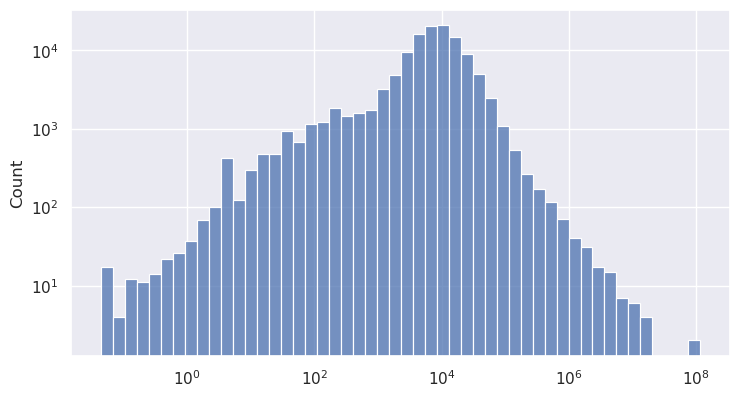

In [25]:
fig_credit_over, ax_credit_over = plt.subplots(figsize=BASE_FIG_SIZE)
sns.histplot(
    bureau.filter(pl.col("AMT_CREDIT_MAX_OVERDUE") > 0)["AMT_CREDIT_MAX_OVERDUE"],
    bins=50,
    ax=ax_credit_over,
    discrete=False,
    log_scale=True,
)
ax_credit_over.set_yscale("log")
plt.show()

The credits can be overdue up to several years, while the amount is mostly in the range of hundreds to millions of currency.

### Currency Information

**Changing the data type of annuity:**

In [26]:
bureau = bureau.with_columns(
    pl.col("AMT_ANNUITY").str.to_decimal().cast(pl.Float64).alias("AMT_ANNUITY")
)

**Amount of annuity in different currencies:**

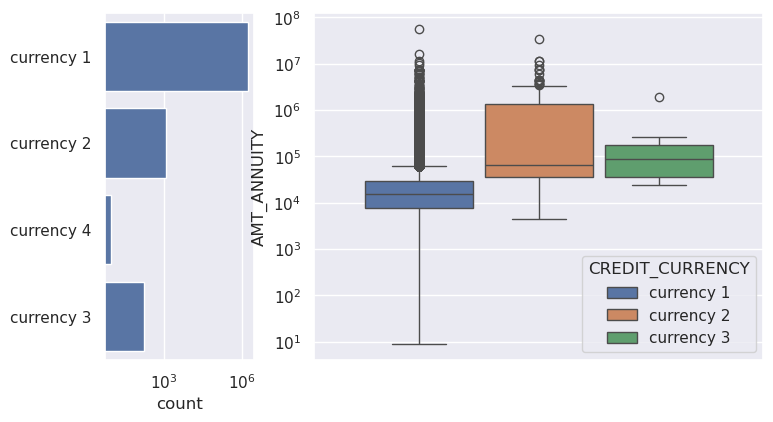

In [27]:
fig_curr, ax_curr = plt.subplots(
    1, 2, figsize=BASE_FIG_SIZE, gridspec_kw={"width_ratios": [1, 3]}
)
sns.countplot(bureau["CREDIT_CURRENCY"], ax=ax_curr[0])
ax_curr[0].set_xscale("log")
sns.boxplot(
    y=bureau[["CREDIT_CURRENCY", "AMT_ANNUITY"]]
    .drop_nulls()
    .filter(pl.col("AMT_ANNUITY") > 0)["AMT_ANNUITY"],
    hue=bureau[["CREDIT_CURRENCY", "AMT_ANNUITY"]]
    .drop_nulls()
    .filter(pl.col("AMT_ANNUITY") > 0)["CREDIT_CURRENCY"],
    gap=0.1,
    ax=ax_curr[1],
)
ax_curr[1].set_yscale("log")

Three different currencies are in use, with the majority of credits denominated in currency 1. Examining the distribution of installment amounts suggests significant disparities in the scales of these currencies. Due to the lack of information on exchange rates and the substantial differences in currency scales, features related to amounts in minority currencies will be excluded from the model.

### Temporal Information About Credit Bureau Entries

**How long ago was the applicants first and last credit application according to credit bureau?:**

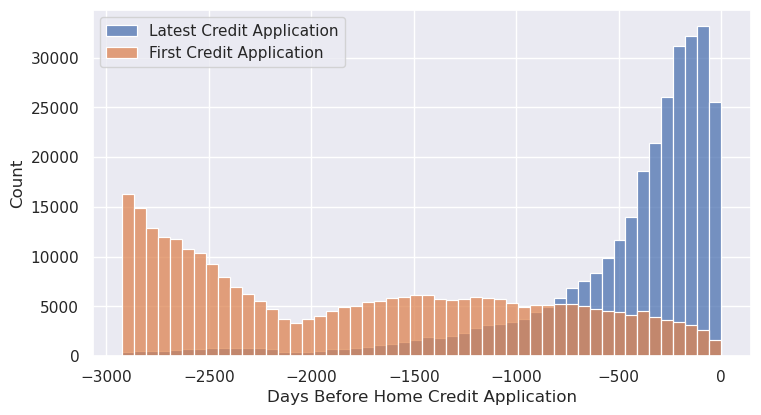

In [28]:
fig_days_bureau, ax_days_bureau = plt.subplots(figsize=BASE_FIG_SIZE)
sns.histplot(
    bureau.group_by("SK_ID_CURR").agg(pl.col("DAYS_CREDIT").max())["DAYS_CREDIT"],
    ax=ax_days_bureau,
    label="Latest Credit Application",
    bins=50,
)
sns.histplot(
    bureau.group_by("SK_ID_CURR").agg(pl.col("DAYS_CREDIT").min())["DAYS_CREDIT"],
    ax=ax_days_bureau,
    label="First Credit Application",
    bins=50,
)
ax_days_bureau.legend()
ax_days_bureau.set_xlabel("Days Before Home Credit Application")
plt.show()

**How many days before the current application has the information been updated:**

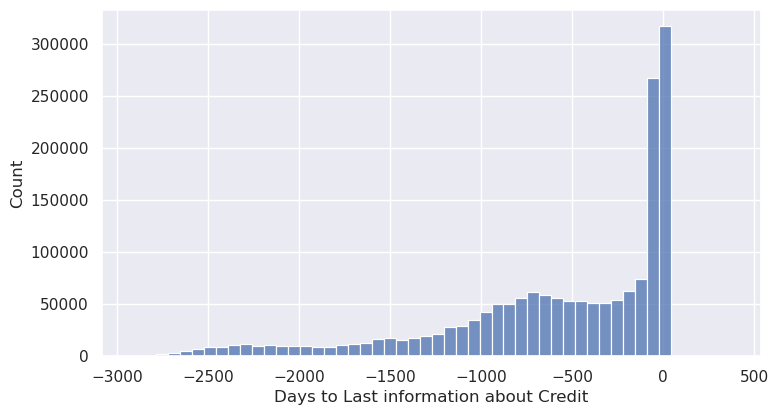

In [29]:
fig_days_update, ax_days_update = plt.subplots(figsize=BASE_FIG_SIZE)
sns.histplot(
    bureau.filter(pl.col("DAYS_CREDIT_UPDATE") > -10000)["DAYS_CREDIT_UPDATE"],
    bins=50,
    ax=ax_days_update,
)
ax_days_update.set_xlabel("Days to Last information about Credit")
plt.show()

**Types of credits in credit bureau information:**

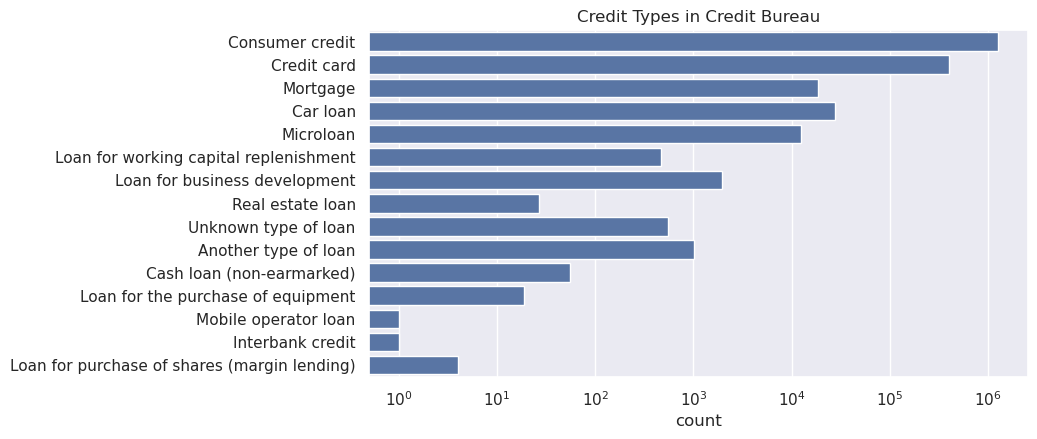

In [30]:
fig_bur_counts, ax_bur_counts = plt.subplots(figsize=BASE_FIG_SIZE)
sns.countplot(bureau["CREDIT_TYPE"], ax=ax_bur_counts)
ax_bur_counts.set_xscale("log")
ax_bur_counts.set_title("Credit Types in Credit Bureau")
plt.show()

### Section Overview

In this section it was determined that:
1. Applicants can possess both active and closed credits.
2. The majority of credit bureau information is in a single currency but two additional currencies are also present.
2. Active credits exhibit overdue status, with some cases extending over several years.
3. Overdue credits vary significantly in terms of currency, ranging from hundreds to millions.
4. The credit bureau retains several years' worth of credit information for each applicant.
5. Notably, a majority of the information within the credit bureau has been recently updated.

## Previous Applications

Some of the current applicants had made applications for loans previously, the company stores data about their previous applications.

**The number of accepted and rejected previous applications per applicant:**

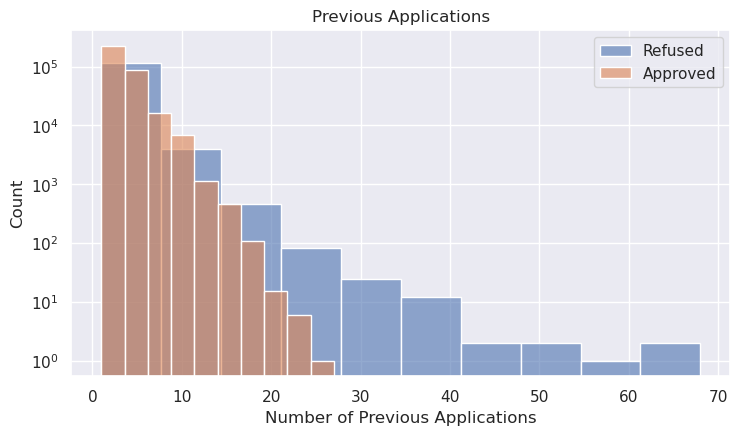

In [31]:
fig_previous_counts, ax_previous_counts = plt.subplots(1, 1, figsize=BASE_FIG_SIZE)
sns.histplot(
    previous_application.filter(pl.col("NAME_CONTRACT_STATUS") == "Refused")
    .group_by("SK_ID_CURR")
    .agg(pl.count())["count"],
    bins=10,
    ax=ax_previous_counts,
    label="Refused",
    alpha=0.6,
)

sns.histplot(
    previous_application.filter(pl.col("NAME_CONTRACT_STATUS") == "Approved")
    .group_by("SK_ID_CURR")
    .agg(pl.count())["count"],
    bins=10,
    ax=ax_previous_counts,
    label="Approved",
    alpha=0.6,
)

ax_previous_counts.legend()
ax_previous_counts.set_title("Previous Applications")
ax_previous_counts.set_xlabel("Number of Previous Applications")
ax_previous_counts.set_yscale("log")

**Types of previous applications:**

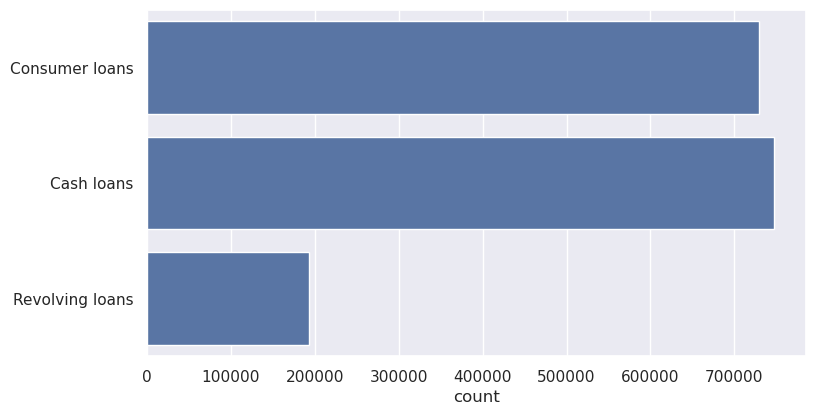

In [32]:
fig_prev_type, ax_prev_type = plt.subplots(figsize=BASE_FIG_SIZE)
sns.countplot(
    previous_application["NAME_CONTRACT_TYPE"].filter(
        previous_application["NAME_CONTRACT_TYPE"] != "XNA"
    ),
    ax=ax_prev_type,
)
plt.show()

**How long ago were the previous applications made?**

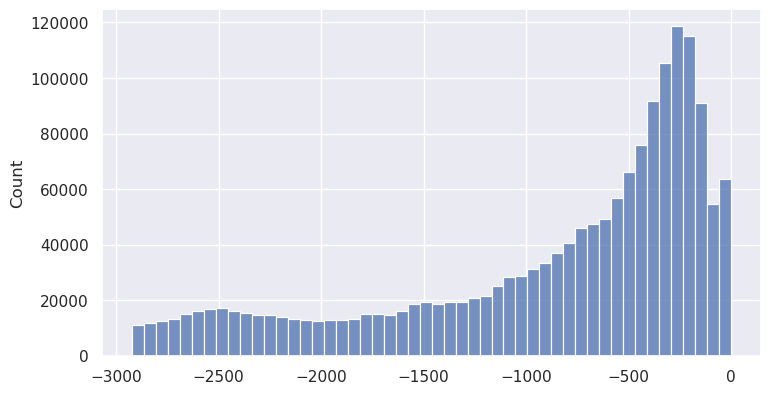

In [33]:
fig_prev_days, ax_prev_days = plt.subplots(figsize=BASE_FIG_SIZE)
sns.histplot(previous_application["DAYS_DECISION"], bins=50, ax=ax_prev_days)
plt.show()

### Installments

**How late and how underpaid were the previous installments?**

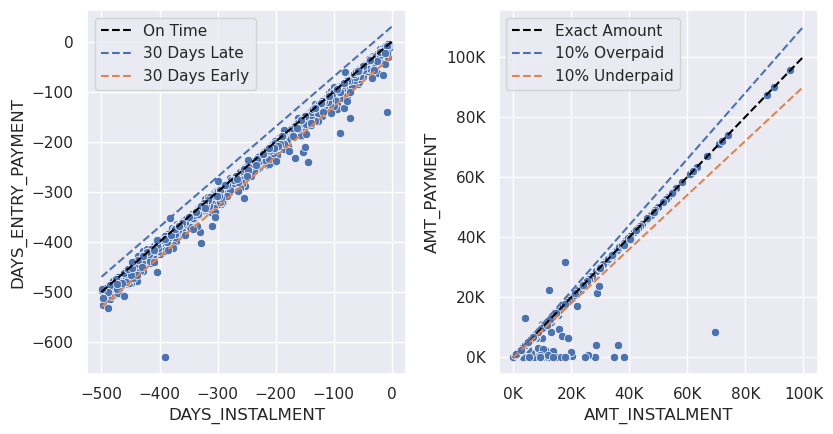

In [34]:
fig_days_late, ax_days_late = plt.subplots(1, 2, figsize=BASE_FIG_SIZE)
x = np.linspace(-500, 0)
sns.scatterplot(
    y=installments_payments.filter(pl.col("DAYS_INSTALMENT") > -500)[
        "DAYS_ENTRY_PAYMENT"
    ].sample(1000, seed=1),
    x=installments_payments.filter(pl.col("DAYS_INSTALMENT") > -500)[
        "DAYS_INSTALMENT"
    ].sample(1000, seed=1),
    ax=ax_days_late[0],
)
sns.lineplot(
    x=x, y=x, linestyle="--", label="On Time", color="black", ax=ax_days_late[0]
)
sns.lineplot(x=x, y=x + 30, linestyle="--", label="30 Days Late", ax=ax_days_late[0])
sns.lineplot(x=x, y=x - 30, linestyle="--", label="30 Days Early", ax=ax_days_late[0])

x_inst = np.linspace(0, 100000)
sns.scatterplot(
    y=installments_payments.filter(pl.col("AMT_INSTALMENT") < 100000)[
        "AMT_PAYMENT"
    ].sample(1000, seed=1),
    x=installments_payments.filter(pl.col("AMT_INSTALMENT") < 100000)[
        "AMT_INSTALMENT"
    ].sample(1000, seed=1),
    ax=ax_days_late[1],
)
sns.lineplot(
    x=x_inst,
    y=x_inst,
    linestyle="--",
    label="Exact Amount",
    color="black",
    ax=ax_days_late[1],
)
sns.lineplot(
    x=x_inst,
    y=x_inst + x_inst * 0.1,
    linestyle="--",
    label="10% Overpaid",
    ax=ax_days_late[1],
)
sns.lineplot(
    x=x_inst,
    y=x_inst - x_inst * 0.1,
    linestyle="--",
    label="10% Underpaid",
    ax=ax_days_late[1],
)
ax_days_late[1].xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)
ax_days_late[1].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)
plt.tight_layout()
plt.show()

### Credit Cards

**Number of credits cards per user:**

In [35]:
credit_card_balance.group_by("SK_ID_CURR").agg(
    pl.col("SK_ID_PREV").n_unique().alias("Number Of Credit Cards")
)["Number Of Credit Cards"].value_counts()

Number Of Credit Cards,counts
u32,u32
3,7
1,102818
2,732
4,1


**Were any credit cards over limit?**

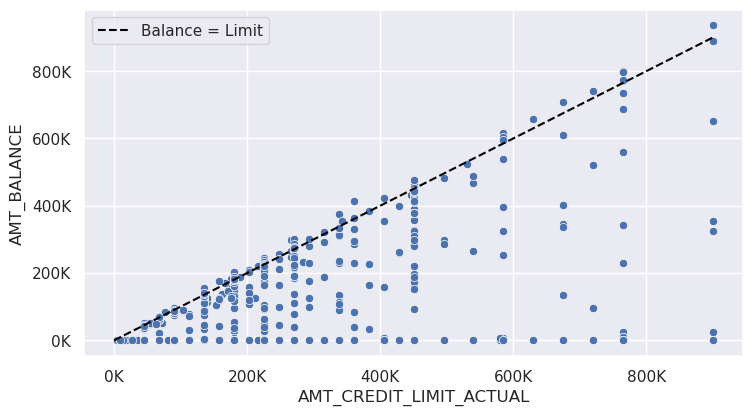

In [36]:
fig_balance, ax_balance = plt.subplots(figsize=BASE_FIG_SIZE)


sns.scatterplot(
    y=credit_card_balance.filter(pl.col("AMT_CREDIT_LIMIT_ACTUAL") > 0)
    .group_by("SK_ID_CURR")
    .agg(pl.all().sort_by("MONTHS_BALANCE").last())
    .sort("SK_ID_CURR")["AMT_BALANCE"]
    .sample(1000, seed=1),
    x=credit_card_balance.filter(pl.col("AMT_CREDIT_LIMIT_ACTUAL") > 0)
    .group_by("SK_ID_CURR")
    .agg(pl.all().sort_by("MONTHS_BALANCE").last())
    .sort("SK_ID_CURR")["AMT_CREDIT_LIMIT_ACTUAL"]
    .sample(1000, seed=1),
    ax=ax_balance,
)

x_bal = np.linspace(0, 900000)
sns.lineplot(
    x=x_bal,
    y=x_bal,
    label="Balance = Limit",
    linestyle="--",
    color="black",
    ax=ax_balance,
)

ax_balance.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)
ax_balance.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)

Some credit cards are over limit, further we determine how many current month active credit cars are over limit and by what amount.

**Filtering for current month active credit cards and checking the limits:**

In [37]:
active_credit_cards = credit_card_balance.filter(
    (pl.col("MONTHS_BALANCE") == -1) & (pl.col("NAME_CONTRACT_STATUS") == "Active")
)

active_credit_cards = active_credit_cards.with_columns(
    pl.when((pl.col("AMT_CREDIT_LIMIT_ACTUAL") - pl.col("AMT_BALANCE")) < 0)
    .then(pl.lit(1, pl.Int16))
    .otherwise(pl.lit(0, pl.Int16))
    .alias("IS_OVER_LIMIT")
)

active_credit_cards = active_credit_cards.with_columns(
    (pl.col("AMT_BALANCE") - pl.col("AMT_CREDIT_LIMIT_ACTUAL")).alias("OVER_LIMIT")
)
active_credit_cards = active_credit_cards.with_columns(
    pl.when(pl.col("OVER_LIMIT") > 0)
    .then(pl.col("OVER_LIMIT"))
    .otherwise(pl.lit(0))
    .alias("OVER_LIMIT")
)

**How many credit cards are over limit and by what amount?**

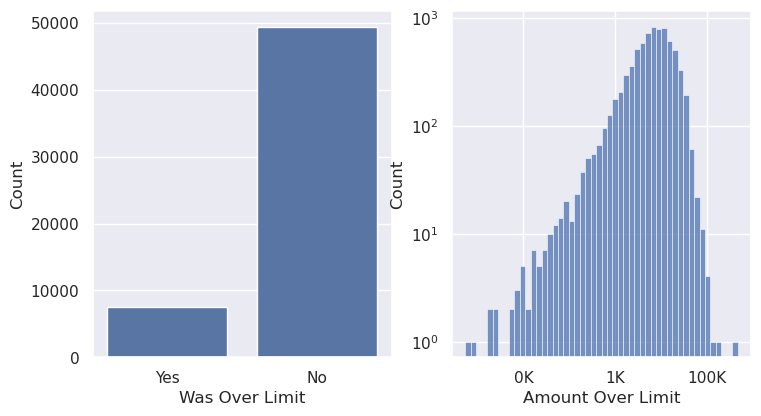

In [38]:
fig_over_limit, ax_over_limit = plt.subplots(1, 2, figsize=BASE_FIG_SIZE)

sns.barplot(
    active_credit_cards["IS_OVER_LIMIT"].value_counts()["counts"], ax=ax_over_limit[0]
)
ax_over_limit[0].set_ylabel("Count")
ax_over_limit[0].set_xlabel("Was Over Limit")
ax_over_limit[0].set_xticks([0, 1])
ax_over_limit[0].set_xticklabels(["Yes", "No"])

sns.histplot(
    active_credit_cards["OVER_LIMIT"].filter(active_credit_cards["OVER_LIMIT"] > 0),
    bins=50,
    ax=ax_over_limit[1],
    log_scale=True,
)
ax_over_limit[1].set_yscale("log")
ax_over_limit[1].xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)
ax_over_limit[1].set_xlabel("Amount Over Limit")
plt.show()

### Consumer Loan Fees

The loans encompass various fees, typically comprising the interest rate along with any additional fees charged by the company. In the absence of a means to separate the interest rate, the focus in this section is directed towards the total sum of fees—encompassing all payments made by the individual excluding the principal loan amount. It's important to note that this analysis specifically centers on consumer loans.

**Calculating the fees of consumer loans:**

In [39]:
consumer_loans = previous_application.filter(
    (pl.col("NAME_CONTRACT_TYPE") == "Consumer loans")
    & (pl.col("NAME_CONTRACT_STATUS") == "Approved")
)

# Irrelevant cols
consumer_loans = consumer_loans.drop(
    columns=["NAME_YIELD_GROUP", "NAME_CONTRACT_STATUS", "NAME_CONTRACT_TYPE"]
)

consumer_loans = consumer_loans.with_columns(
    ((pl.col("AMT_ANNUITY") * pl.col("CNT_PAYMENT") - pl.col("AMT_CREDIT"))).alias(
        "FEES_AMT"
    )
)

consumer_loans = consumer_loans.with_columns(
    (
        (pl.col("AMT_ANNUITY") * pl.col("CNT_PAYMENT") - pl.col("AMT_CREDIT"))
        / pl.col("AMT_CREDIT")
        * 100
    ).alias("FEES_PERCENT")
)

**The amount of fees for consumer loans as a percentage of the loan and a total amount:**

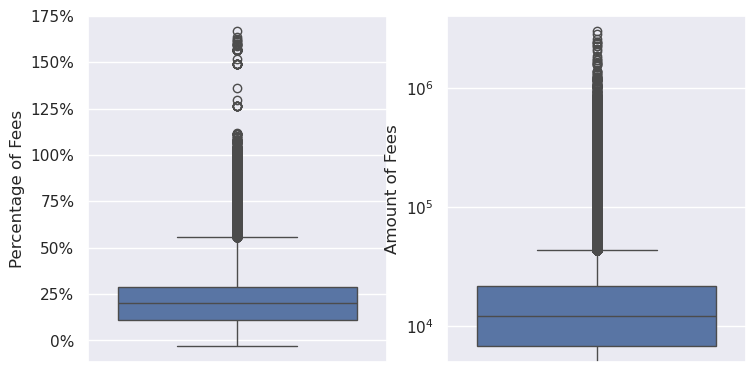

In [40]:
fig_fees, ax_fees = plt.subplots(1, 2, figsize=BASE_FIG_SIZE)

sns.boxplot(consumer_loans["FEES_PERCENT"], ax=ax_fees[0])
ax_fees[0].set_ylabel("Percentage of Fees")
ax_fees[0].yaxis.set_major_formatter(ticker.PercentFormatter())

sns.boxplot(consumer_loans["FEES_AMT"], ax=ax_fees[1])
ax_fees[1].set_yscale("log")
ax_fees[1].set_ylabel("Amount of Fees")
plt.show()

**Percentage of fees for different consumer loan goods categories:**

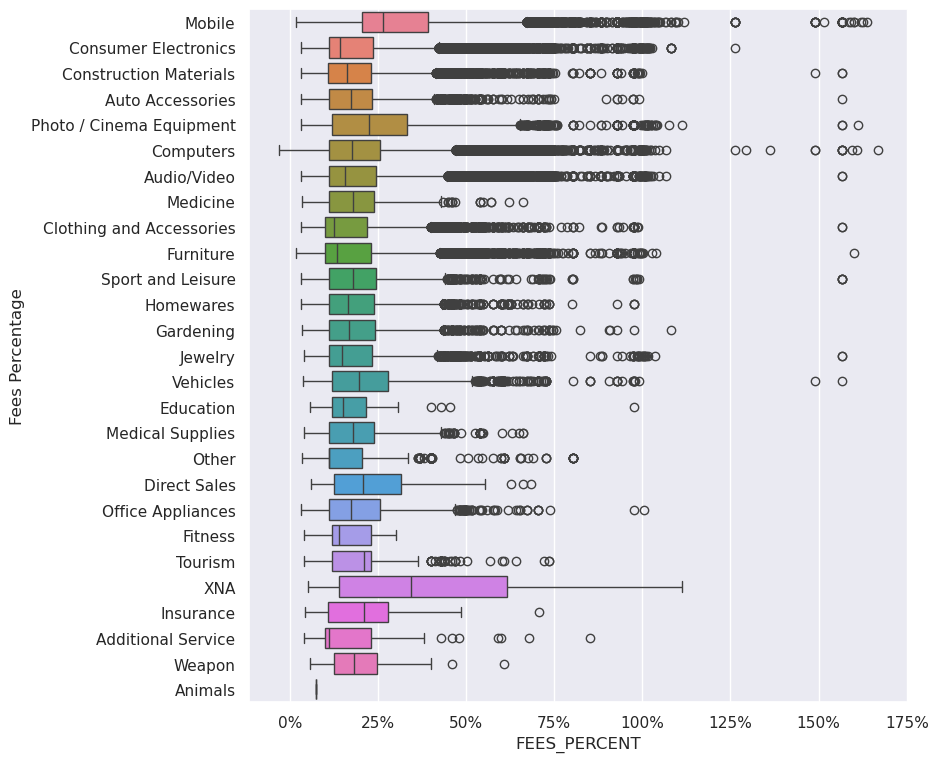

In [41]:
fig_consumer_amt, ax_consumer_amt = plt.subplots(
    figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 2)
)
sns.boxplot(
    x=consumer_loans["FEES_PERCENT"],
    y=consumer_loans["NAME_GOODS_CATEGORY"],
    hue=consumer_loans["NAME_GOODS_CATEGORY"],
    ax=ax_consumer_amt,
)
ax_consumer_amt.set_ylabel("Goods Category")
ax_consumer_amt.set_ylabel("Fees Percentage")
ax_consumer_amt.xaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

It is evident that consumer loans for different goods tend to have different fees, with the general trend being higher fees for luxury goods.

### Section Summary

In this section it was determined that:
1. Applicants have a history of up to 70 rejected previous applications and up to 30 accepted previous applications.
2. Although the majority of previous applications were submitted in the last couple of years, some date back as far as 8 years.
3. Instances of late or underpaid installments were observed in some of the previous applications.
4. Notably, certain credit cards from past applications are both over limit and involve amounts of up to 100k in currency, prompting consideration for an additional predictive modeling avenue.
5. The amount of fees associated with loans, paid by the consumer, will be pursued as the third target for predictive modeling.